In [ ]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import metrics
import scipy.optimize as opt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Used for plotting later
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#F7345E','#80C3BD'])
cmap_light = ListedColormap(['#FFF4E5','#D2E3EF'])


In [ ]:
# Read the file 'agriland.csv' as a Pandas dataframe
df = pd.read_csv('agriland.csv')

# Take a quick look at the data
# Note that the latitude & longitude values are normalized
df.head()


,latitude,longitude,land_type
0,-0.071860,-1.297410,1.0
1,-0.179482,-0.874892,1.0
2,-1.217428,-1.352105,0.0
3,1.143306,-0.894172,1.0
4,-3.033199,0.818646,0.0


In [ ]:
# Set the values of latitude & longitude predictor variables
X = df[['latitude','longitude']].values

# Use the column "land_type" as the response variable
y = df['land_type'].values


In [ ]:
# Split data in train an test, with test size = 0.2 
# and set random state as 44
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=44)


In [ ]:
# Define the max_depth of the decision tree
max_depth = 5

# Define a decision tree classifier with a max depth as defined above
# and set the random_state as 44
clf = DecisionTreeClassifier(max_depth = max_depth, random_state = 44)

# Fit the model on the training data
clf.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=5, random_state=44)

In [ ]:
# Use the trained model to predict on the test set
prediction = clf.predict(X_test)

# Calculate the accuracy of the test predictions of a single tree
single_acc = accuracy_score(y_test,prediction)

# Print the accuracy of the tree
print(f'Single tree Accuracy is {single_acc*100}%')


Single tree Accuracy is 82.5%


In [ ]:
# Complete the function below to get the prediction by bagging

# Inputs: X_train, y_train to train your data
# X_to_evaluate: Samples that you are goin to predict (evaluate)
# num_bootstraps: how many trees you want to train
# Output: An array of predicted classes for X_to_evaluate

def prediction_by_bagging(X_train, y_train, X_to_evaluate, num_bootstraps):
    
    # List to store every array of predictions
    predictions = []
    
    # Generate num_bootstraps number of trees
    for i in range(num_bootstraps):
        
        # Sample data to perform first bootstrap, here, we actually bootstrap indices, 
        # because we want the same subset for X_train and y_train
        resample_indexes = np.random.choice(np.arange(y_train.shape[0]), size=y_train.shape[0])
        
        # Get a bootstrapped version of the data using the above indices
        X_boot = X_train[resample_indexes]
        y_boot = y_train[resample_indexes]
        
        # Initialize a Decision Tree on bootstrapped data 
        # Use the same max_depth and random_state as above
        clf = DecisionTreeClassifier(max_depth = 5, random_state = 44)
        
        # Fit the model on bootstrapped training set
        clf.fit(X_boot,y_boot)
        
        # Use the trained model to predict on X_to_evaluate samples
        pred = clf.predict(X_to_evaluate)
        
        # Append the predictions to the predictions list
        predictions.append(pred)

    # The list "predictions" has [prediction_array_0, prediction_array_1, ..., prediction_array_n]
    # To get the majority vote for each sample, we can find the average 
    # prediction and threshold them by 0.5
    average_prediction = (np.mean(predictions,axis=0) > 0.5 )*1
    
    # Return the average prediction
    return average_prediction


In [ ]:
### edTest(test_bag_acc) ###         


# Define the number of bootstraps
num_bootstraps = 200

# Calling the prediction_by_bagging function with appropriate parameters
y_pred = prediction_by_bagging(X_train,y_train,X_test,num_bootstraps=num_bootstraps)

# Compare the average predictions to the true test set values 
# and compute the accuracy 
bagging_accuracy = accuracy_score(y_test,y_pred)

# Print the bagging accuracy
print(f'Accuracy with Bootstrapped Aggregation is  {bagging_accuracy*100}%')


Accuracy with Bootstrapped Aggregation is  87.5%


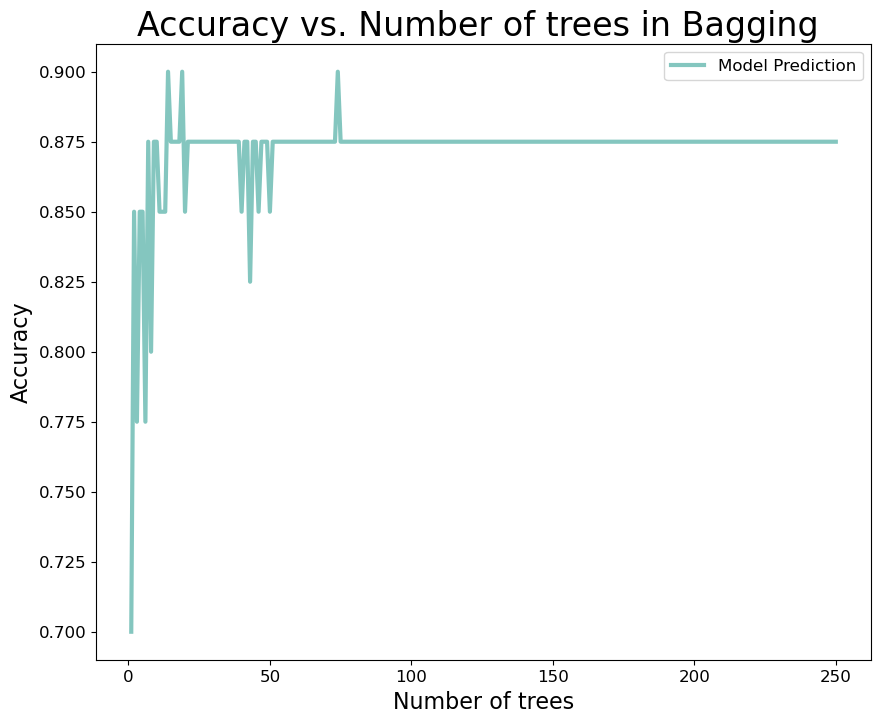

In [ ]:
# Helper code to plot accuracy vs number of bagged trees

n = np.linspace(1,250,250).astype(int)
acc = []
for n_i in n:
    acc.append(np.mean(prediction_by_bagging(X_train, y_train, X_test, n_i)==y_test))
plt.figure(figsize=(10,8))
plt.plot(n,acc,alpha=0.7,linewidth=3,color='#50AEA4', label='Model Prediction')
plt.title('Accuracy vs. Number of trees in Bagging ',fontsize=24)
plt.xlabel('Number of trees',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show();


## Bagging Visualization

Bagging does well to reduce overfitting, but only upto a certain extent.

Vary the `max_depth` and `numboot` variables to see how Bagging helps reduce overfitting with the help of the visualization below

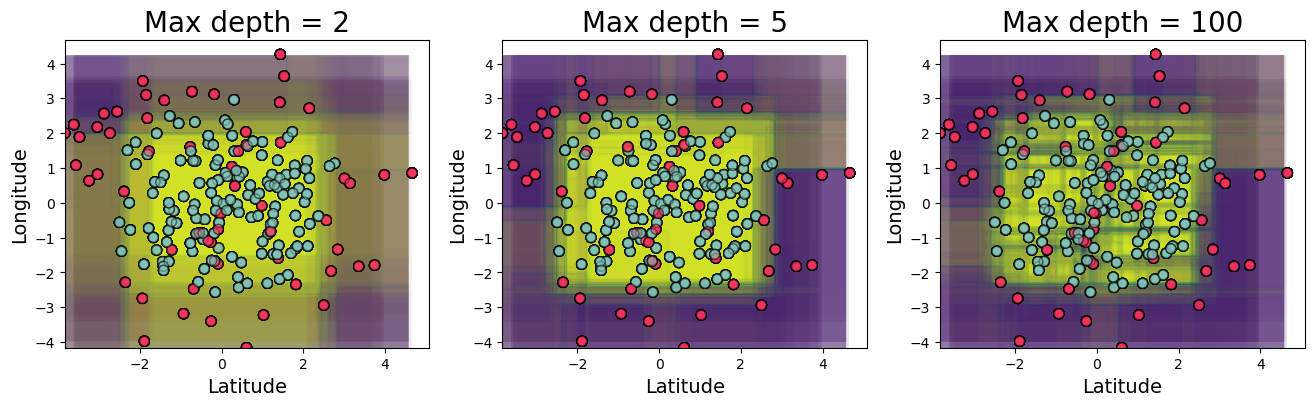

In [ ]:
# Making plots for three different values of `max_depth`
fig,axes = plt.subplots(1,3,figsize=(16,4))

# Make a list of three max_depths to investigate
max_depth = [2,5,100]

# Fix the number of bootstraps
numboot = 100

for index,ax in enumerate(axes):

    for i in range(numboot):
        df_new = df.sample(frac=1,replace=True)
        y = df_new.land_type.values
        X = df_new[['latitude', 'longitude']].values
        dtree = DecisionTreeClassifier(max_depth=max_depth[index])
        dtree.fit(X, y)
        ax.scatter(X[:, 0], X[:, 1], c=y-1, s=50,alpha=0.5,edgecolor="k",cmap=cmap_bold) 
        plot_step_x1= 0.1
        plot_step_x2= 0.1
        x1min, x1max= X[:,0].min(), X[:,0].max()
        x2min, x2max= X[:,1].min(), X[:,1].max()
        x1, x2 = np.meshgrid(np.arange(x1min, x1max, plot_step_x1), np.arange(x2min, x2max, plot_step_x2) )
        # Re-cast every coordinate in the meshgrid as a 2D point
        Xplot= np.c_[x1.ravel(), x2.ravel()]

        # Predict the class
        y = dtree.predict( Xplot )
        y= y.reshape( x1.shape )
        cs = ax.contourf(x1, x2, y, alpha=0.02)
        
    ax.set_xlabel('Latitude',fontsize=14)
    ax.set_ylabel('Longitude',fontsize=14)
    ax.set_title(f'Max depth = {max_depth[index]}',fontsize=20)



## Mindchow 🍲
Play around with the following parameters:

- max_depth
- numboot

Based on your observations, answer the questions below:

- How does the plot change with varying `max_depth`

- How does the plot change with varying `numboot`

- How are the three plots essentially different?

- Does more bootstraps reduce overfitting for
    - High depth
    - Low depth